## データビリティコンソーシアム eラーニング講座：AIを体系的に学ぶ
## 知識情報学（第5回）回帰
- MIT License

## 糖尿病の進行度推定と特徴選択

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt

### Diabetesデータのロード

In [2]:
df = load_diabetes()
X = scale(df.data)
y = df.target
df.feature_names = np.array(df.feature_names)

print(df.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

## 線形回帰＋逐次特徴選択（SFS）
- SequentialFeatureSelector:
  - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
- 学習データ（50%）で特徴選択を行い，テストデータ（50%）に対して交差検証を行う

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=2)

### 特徴選択を行わない線形回帰

In [4]:
lr = LinearRegression()
scores = cross_val_score(lr, X_test, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

R2 score 0.4250


### 【オンライン演習1】 線形回帰＋前進特徴選択

In [6]:
lr_forward = LinearRegression()
# SequentialFeatureSelectorを前進特徴選択，選択特徴数5, 交差検証のFold数5でインスタンス生成（初期化）する
sfs_forward = SequentialFeatureSelector(lr_forward,
                                        scoring = 'r2',
                                        direction='forward',
                                        n_features_to_select=5,
                                        cv=5)
sfs_forward.fit(X_train, y_train)

# get_support()で選択された特徴量のMaskが取得できる
print("Selected feature mask:", sfs_forward.get_support())
# 選択された特徴名の表示
print("Selected feature names:", df.feature_names[sfs_forward.get_support()])

Selected feature mask: [False  True  True  True False False  True False  True False]
Selected feature names: ['sex' 'bmi' 'bp' 's3' 's5']


In [7]:
# テストデータを選択された特徴のみに削減
X_test_selected1 = sfs_forward.transform(X_test)
# 特徴数が削減されていることを確認
print(X_test_selected1.shape)

lr_selected1 = LinearRegression()
scores = cross_val_score(lr_selected1, X_test_selected1, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(221, 5)
R2 score 0.4216


### 【オンライン演習2】 線形回帰＋後退特徴選択

In [8]:
# 上記の前進特徴選択を後退特徴選択に変更する
lr_backward = LinearRegression()
sfs_backward = SequentialFeatureSelector(lr_backward,
                                         scoring = 'r2',
                                         direction='backward',
                                         n_features_to_select=5,
                                         cv=5)
sfs_backward.fit(X_train, y_train)
print("Selected feature mask:", sfs_backward.get_support())
print("Selected feature names:", df.feature_names[sfs_backward.get_support()])

X_test_selected2 = sfs_backward.transform(X_test)
lr_selected2 = LinearRegression()
scores = cross_val_score(lr_selected2, X_test_selected2, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

Selected feature mask: [False  True  True  True False False  True False  True False]
Selected feature names: ['sex' 'bmi' 'bp' 's3' 's5']
R2 score 0.4216


## モデルベース特徴選択
- 特徴量の重要度の算出が可能なモデルをベースとした特徴選択
- SelectFromModel:
  - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
  
### 1. Lasso回帰
- Lasso:
  - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [9]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [10]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
# 学習済み重みを表示
lasso.coef_

array([ -0.19512245, -12.45996611,  18.73751335,  16.13507338,
        -0.        ,  -3.37480673, -11.11897238,  -0.        ,
        30.92342405,   1.46927353])

### 重要度に基づいた特徴選択
- 非ゼロ要素が選択される

In [11]:
lasso_selected = SelectFromModel(lasso, prefit=True)
X_test_selected3 = lasso_selected.transform(X_test)
print(X_test_selected3.shape)
print("Selected feature names:", df.feature_names[lasso_selected.get_support()])

lr_lasso_selected = LinearRegression()
scores = cross_val_score(lr_lasso_selected, X_test_selected3, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(221, 8)
Selected feature names: ['age' 'sex' 'bmi' 'bp' 's2' 's3' 's5' 's6']
R2 score 0.4171


### 【オンライン演習3】 決定木に基づく重要度の表示
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [12]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [13]:
dtr = DecisionTreeRegressor(max_depth=4)
dtr.fit(X_train, y_train)
# 決定木に基づく重要度の表示
print(dtr.feature_importances_)

[0.0689417  0.01483668 0.12747315 0.08302312 0.         0.
 0.         0.02868456 0.60024634 0.07679445]


### 特徴選択前の決定木の描画

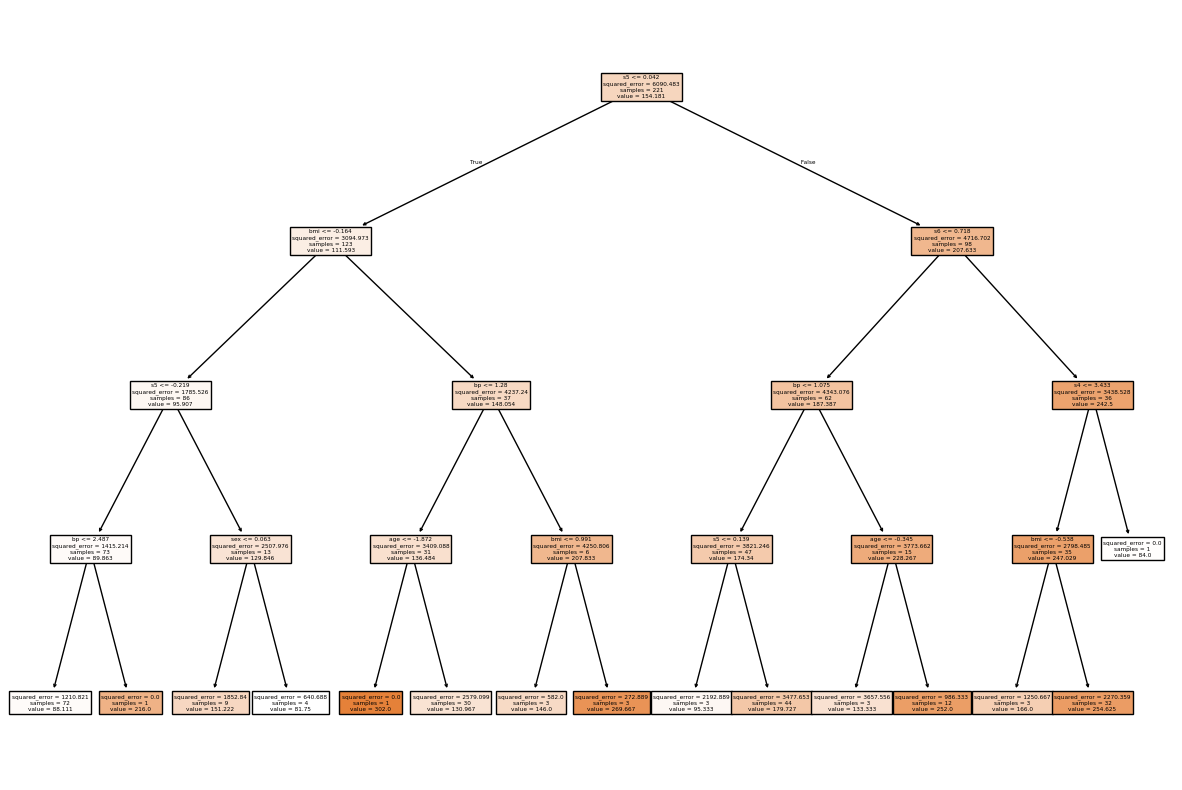

In [14]:
plt.figure(figsize=(15, 10))
plot_tree(dtr, feature_names=df.feature_names, filled=True)
plt.show()

### 【提出課題1】決定木に基づく重要度による特徴選択
- SelectFromModelを用いて特徴選択を行い，テストデータを選択された特徴のみに削減する
- 選択された特徴名を表示する
- テストデータに対して10Fold-交差検証を行い平均R2スコアを表示する

In [15]:
dtr_selected = SelectFromModel(dtr, prefit=True)
X_test_selected4 = dtr_selected.transform(X_test)
print("Selected feature names:",
      df.feature_names[dtr_selected.get_support()])

dtr_model_selected = DecisionTreeRegressor(max_depth=4)
scores = cross_val_score(dtr_model_selected,
                         X_test_selected4, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

Selected feature names: ['bmi' 's5']
R2 score 0.3142


### 【提出課題2】特徴選択後の決定木の描画
- 学習データに対して選択された特徴のみで決定木を再学習し描画する

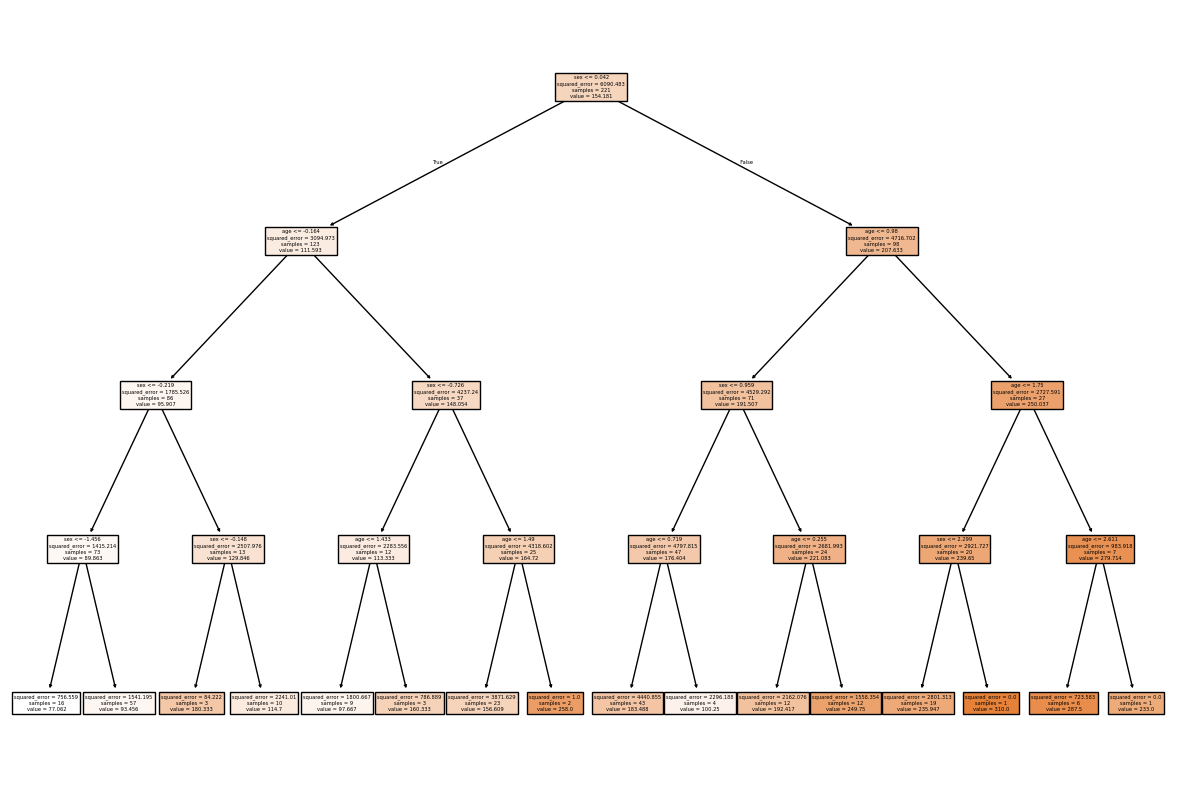

In [16]:
X_train_selected4 = dtr_selected.transform(X_train)
dtr_model_selected.fit(X_train_selected4, y_train)
plt.figure(figsize=(15, 10))
plot_tree(dtr_model_selected, feature_names=df.feature_names, filled=True)
plt.show()